Class-Attention in Image Transformers

In [1]:
! pip install datasets transformers[torch]

In [1]:
from datasets import load_dataset

ds = load_dataset('jonathan-roberts1/RSSCN7')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2800
    })
})

In [3]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x400>,
 'label': 1}

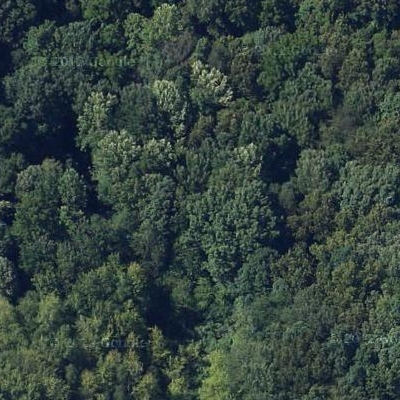

In [4]:
image = ex['image']
image

In [5]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['field', 'forest', 'grass', 'industry', 'parking', 'resident', 'river or lake'], id=None)

In [6]:
labels.int2str(ex['label'])

'forest'

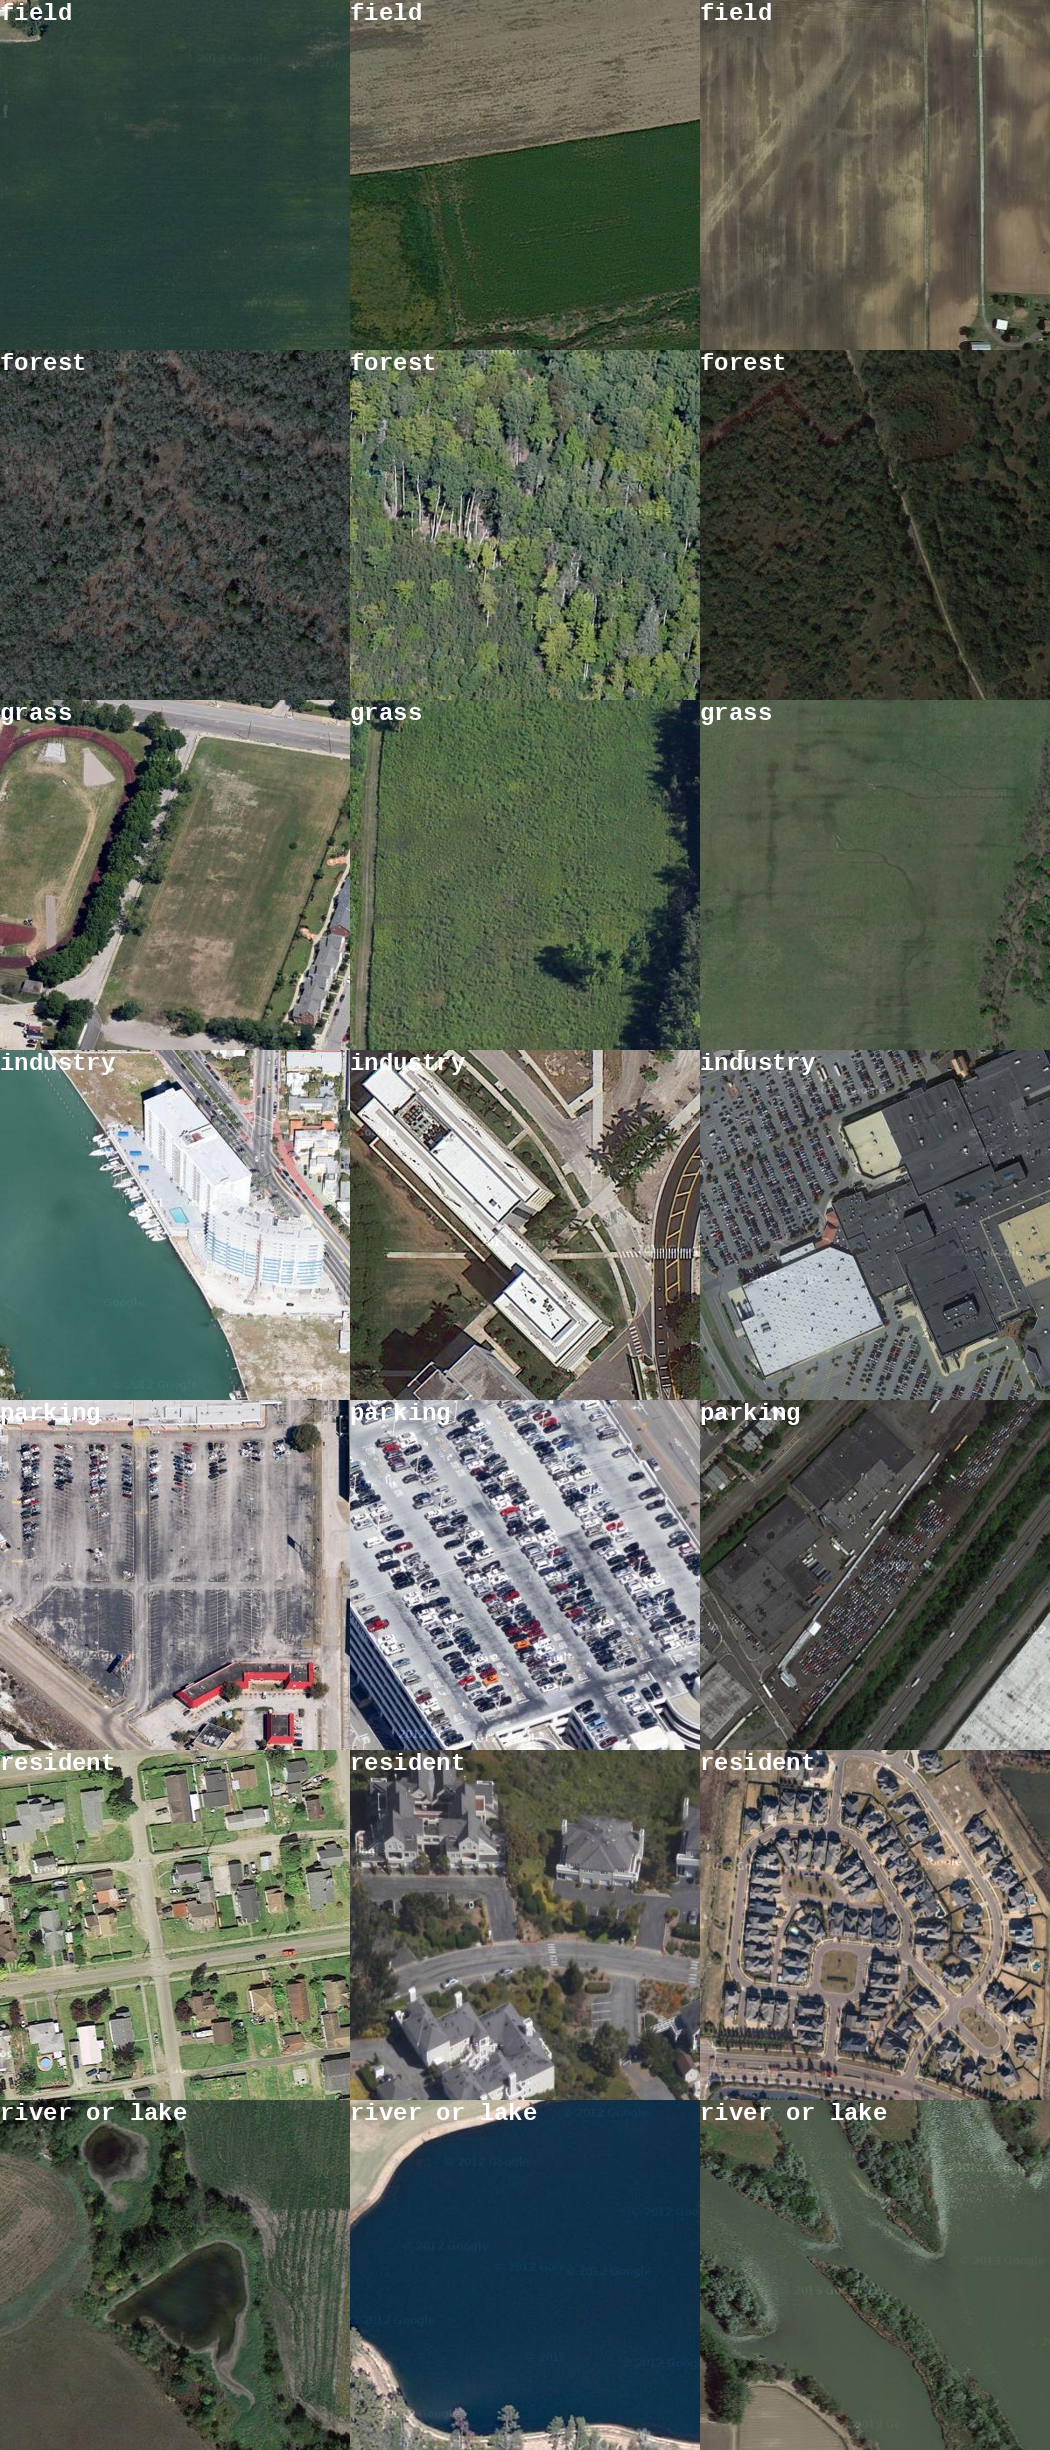

In [7]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [8]:
!pip install timm

In [2]:
prepared_ds=ds['train'].train_test_split(test_size=0.2)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2240
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 560
    })
})

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Split the dataset into train and test sets
train_dataset = CustomDataset(prepared_ds['train'], transform=transform)
test_dataset = CustomDataset(prepared_ds['test'], transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [24]:
from transformers import AutoFeatureExtractor
import timm
import torch

import timm
import torch.nn as nn

# Load the model
model = timm.create_model('timm/cait_s24_224.fb_dist_in1k', pretrained=True, num_classes=7)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): LayerScaleBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_l): Linear(in_features=8, out_features=8, bias=True)
        (proj_w): Linear(in_features=8, out_features=8, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [14]:
!pip install huggingface_hub

In [25]:
import torch.optim as optim
import torch.nn as nn
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
# Training function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    print("Training complete")

# Train the model
train_model(model, train_loader, criterion, optimizer, scheduler)

Epoch 1/10, Loss: 0.09496017545461655
Epoch 2/10, Loss: 0.21147115528583527
Epoch 3/10, Loss: 0.002791820326820016
Epoch 4/10, Loss: 0.0015396919334307313
Epoch 5/10, Loss: 0.00769076868891716
Epoch 6/10, Loss: 0.0006451132358051836
Epoch 7/10, Loss: 0.0003705337585415691
Epoch 8/10, Loss: 0.00036253442522138357
Epoch 9/10, Loss: 0.000645774242002517
Epoch 10/10, Loss: 0.00042586561175994575
Training complete


In [27]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 97.14285714285714%


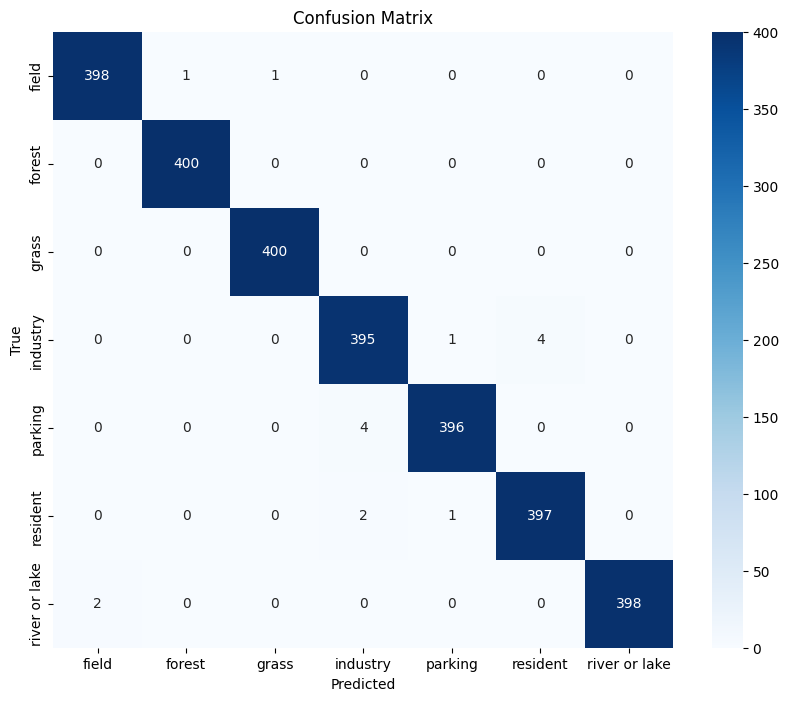

In [28]:
from torch.utils.data import DataLoader ,ConcatDataset
concatenated_dataset = ConcatDataset([train_dataset,test_dataset])
zero_loader = DataLoader(concatenated_dataset, batch_size=16)
zero_loader
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to get predictions and true labels
def get_predictions(model, zero_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in zero_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Get the true labels and predicted labels
true_labels, predicted_labels = get_predictions(model, zero_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds['train'].features['label'].names, yticklabels=ds['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Multiscale Vision Transformer

In [16]:
from transformers import AutoFeatureExtractor
import timm
import torch

import timm
import torch.nn as nn

# Load the model
model = timm.create_model('timm/mvitv2_base_cls.fb_inw21k', pretrained=True, num_classes=7)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): 

In [17]:
import torch.optim as optim
import torch.nn as nn
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
# Training function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    print("Training complete")

# Train the model
train_model(model, train_loader, criterion, optimizer, scheduler)

Epoch 1/10, Loss: 0.29867061972618103
Epoch 2/10, Loss: 0.27929407358169556
Epoch 3/10, Loss: 0.007905102334916592
Epoch 4/10, Loss: 0.006159945856779814
Epoch 5/10, Loss: 0.0035789934918284416
Epoch 6/10, Loss: 0.004063487518578768
Epoch 7/10, Loss: 0.0033412291668355465
Epoch 8/10, Loss: 0.0017424067482352257
Epoch 9/10, Loss: 0.0033695492893457413
Epoch 10/10, Loss: 0.0015899009304121137
Training complete


In [19]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 96.60714285714286%


In [21]:
from torch.utils.data import DataLoader ,ConcatDataset
concatenated_dataset = ConcatDataset([train_dataset,test_dataset])
zero_loader = DataLoader(concatenated_dataset, batch_size=16)
zero_loader

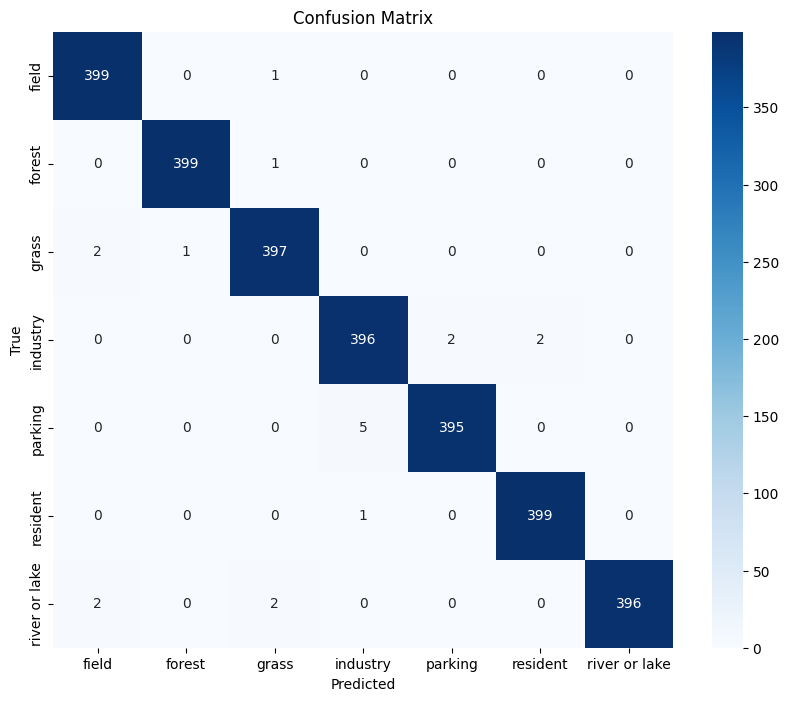

In [23]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to get predictions and true labels
def get_predictions(model, zero_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in zero_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Get the true labels and predicted labels
true_labels, predicted_labels = get_predictions(model, zero_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds['train'].features['label'].names, yticklabels=ds['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()